# Univariate Feature Selection

The goal of this article is to reproduce ... from book "An Introduction to Information Retrieval" and show one approach to feature selection...


## Mutual Information

[*Mutual information*](https://en.wikipedia.org/wiki/Mutual_information) (MI) is a measure of mutual dependence between two random variables. It measures "the amount of information" we get about one random variable through another random variable. The formula to calculate MI for two discrete random variables is:

$$ I(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log{\bigg( \frac{p(x,y)}{p(x)p(y)} \bigg)}. $$

How is this formula derived? MI is linked to the concept of [*entropy*](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which defines "the amount of information" held in a random variable. Entropy is calculated by the following formula:

$$ H(X) = -\sum_{x \in X} p(x) \log{p(x)}. $$

In this article we use 2 as a base of logarithm.

There are several ways for intuitive understanding of the entropy formula. One way to think about the entropy is the "amount" of uncertainty (or the "amount of surprise") about the random variable value. Consider random variable with the following probability mass function:

$$
p(X = x) =
  \begin{cases}
    1, & \text{if } x=x_0 \\
    0, & \text{otherwise}.
  \end{cases}
$$

In other words, random variable always takes value $x_o$. In this case entropy is minimal:

$$ H(X) = -p(x_0) \cdot \log{p(x_0)} = -1 \cdot \log{1} = 0.$$

Entropy takes maximum value when all values of a random variable are equally likely. This is quite intuitive, since in this case we can expect maximum surprise for the variable value. For example, if a random variable can take 4 different values equally likely, then entropy is:

$$ H(X) = -4 \cdot \frac{1}{4} \cdot \log{\frac{1}{4}} = -1 \cdot (-2) = 2.$$

Another way to think about entropy is the minimum number of bits required to deliver the random variable value. In the previous example we can effectively represent the value with 2 bits. Can we do better if values are not equally probable. 

[Huffman coding](https://en.wikipedia.org/wiki/Huffman_coding)

$$
\begin{align}
I(X; Y) &= H(X) + H(Y) - H(X;Y) \\
        &= -\sum_x p(x) \log{p(x)} -\sum_y p(y) \log{p(y)} + \sum_{x,y} p(x,y) \log{p(x,y)} \\
        &= -\sum_x \Big(\sum_y p(y|x)\Big) p(x) \log{p(x)} -\sum_y \Big(\sum_x p(x|y)\Big) p(y) \log{p(y)} + \sum_{x,y} p(x,y) \log{p(x,y)} \\
        &= -\sum_{x,y} p(y|x) p(x) \log{p(x)} -\sum_{x,y} p(x|y) p(y) \log{p(y)} + \sum_{x,y} p(x,y) \log{p(x,y)} \\
        &= -\sum_{x,y} p(x,y) \log{p(x)} -\sum_{x,y} p(x,y) \log{p(y)} + \sum_{x,y} p(x,y) \log{p(x,y)} \\
        &= \sum_{x,y} p(x,y) \Big( -\log{p(x)} -\log{p(y)} + \log{p(x,y)} \Big) \\
        &= \sum_{x,y} p(x,y) \log{\bigg( \frac{p(x,y)}{p(x)p(y)} \bigg)}.
\end{align}
$$


![Relationship of information measures](diagram_small.png)



In [1]:
from sklearn.datasets import fetch_20newsgroups

remove = ['headers', 'footers']
newsgroups_train = fetch_20newsgroups(subset='train', remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', remove=remove)

In [3]:
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [4]:
print("Train posts: %d" % len(newsgroups_train.data))
print("Test posts: %d" % len(newsgroups_test.data))

Train posts: 11314
Test posts: 7532


In [5]:
MAX_TEXT_LEN = 200
for i in range(5):
    print(newsgroups_train.target_names[newsgroups_train.target[i]])
    print(newsgroups_train.data[i][:MAX_TEXT_LEN])
    print("----------------------")

rec.autos
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were 
----------------------
comp.sys.mac.hardware
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed at
----------------------
comp.sys.mac.hardware
well folks, my mac plus finally gave up the ghost this weekend after
starting life as a 512k way back in 1985.  sooo, i'm in the market for a
new machine a bit sooner than i intended to be...

i'm loo
----------------------
comp.graphics
Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-leve
----------------------
sci.space
From article <C5owCB.n3p@w

If not present, Spacy can be installed using the following commands:

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en

In [2]:
import spacy

nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

def clean_text(text):
    # Current version of Spacy recognizes only lower-case stop words.
    # https://github.com/explosion/spaCy/issues/1889
    # So we convert text to lower case as a workaround
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc
        if not token.is_punct and not token.is_stop and token.is_alpha])

print(clean_text("This is a test sentence, and here is a bunch of numbers to skip: 42, 100."))

test sentence bunch number skip


In [3]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

train_data = [clean_text(text) for text in newsgroups_train.data]
test_data = [clean_text(text) for text in newsgroups_test.data]

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

CPU times: user 3min 20s, sys: 337 ms, total: 3min 20s
Wall time: 3min 21s


In [8]:
feature_names = vectorizer.get_feature_names()
print(len(feature_names), feature_names[2000:2010])

49856 ['anulment', 'anulments', 'anus', 'anvil', 'anwar', 'anxietous', 'anxiety', 'anxious', 'anxiously', 'anyboby']


In [87]:
from sklearn.naive_bayes import MultinomialNB
#from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def estimate_model_accuracy(X_train_, y_train_, X_test_, y_test_):
    clf = MultinomialNB(alpha=0.01)
    clf.fit(X_train_, y_train_)
    pred = clf.predict(X_test_)
    return roc_auc_score(y_test_, pred)

In [38]:
MAX_KEYWORD_COUNT=20
def get_keywords(scoring, feature_names):
    # Chi2 returns scores and p-values. We need to extract scores.
    if len(scoring) == 2:
        scoring = scoring[0]
    
    keywords = ""
    for i in scoring.argsort()[-MAX_KEYWORD_COUNT:][::-1]:
        keywords += "%06f\t%s\n" % (scoring[i], feature_names[i])
    return keywords

In [92]:
%%time

from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

#groups = ['comp.graphics']
groups = ['rec.autos']

STEPS_COUNT = 50
keywords_table = []
accuracy_scores = []
for group in groups:
    print("Processing group '%s'..." % group)
    group_index = newsgroups_train.target_names.index(group)
    row = [group]
    
    y_train = [int(y == group_index) for y in newsgroups_train.target]
    y_test = [int(y == group_index) for y in newsgroups_test.target]
    
    scorings = [
        chi2(X_train, y_train),
        mutual_info_classif(X_train, y_train, discrete_features=True)
    ]
    for scoring in scorings:
        row.append(get_keywords(scoring, feature_names))
    
    accuracy = [[], [], []]
    for i in range(STEPS_COUNT):
        feature_count = int(X_train.shape[1] * (i+1) / STEPS_COUNT / 50)
        
        accuracy[0].append(
            estimate_model_accuracy(X_train[:,:feature_count], y_train,
                                    X_test[:,:feature_count], y_test))

        for j, scoring in enumerate(scorings):
            selection = SelectKBest((lambda x, y: scoring), k=feature_count)
            accuracy[j+1].append(
                estimate_model_accuracy(selection.fit_transform(X_train, y_train), y_train,
                                        selection.transform(X_test), y_test))

    accuracy_scores.append(accuracy)
    keywords_table.append(row)

Processing group 'rec.autos'...
CPU times: user 1min 49s, sys: 362 ms, total: 1min 49s
Wall time: 1min 50s


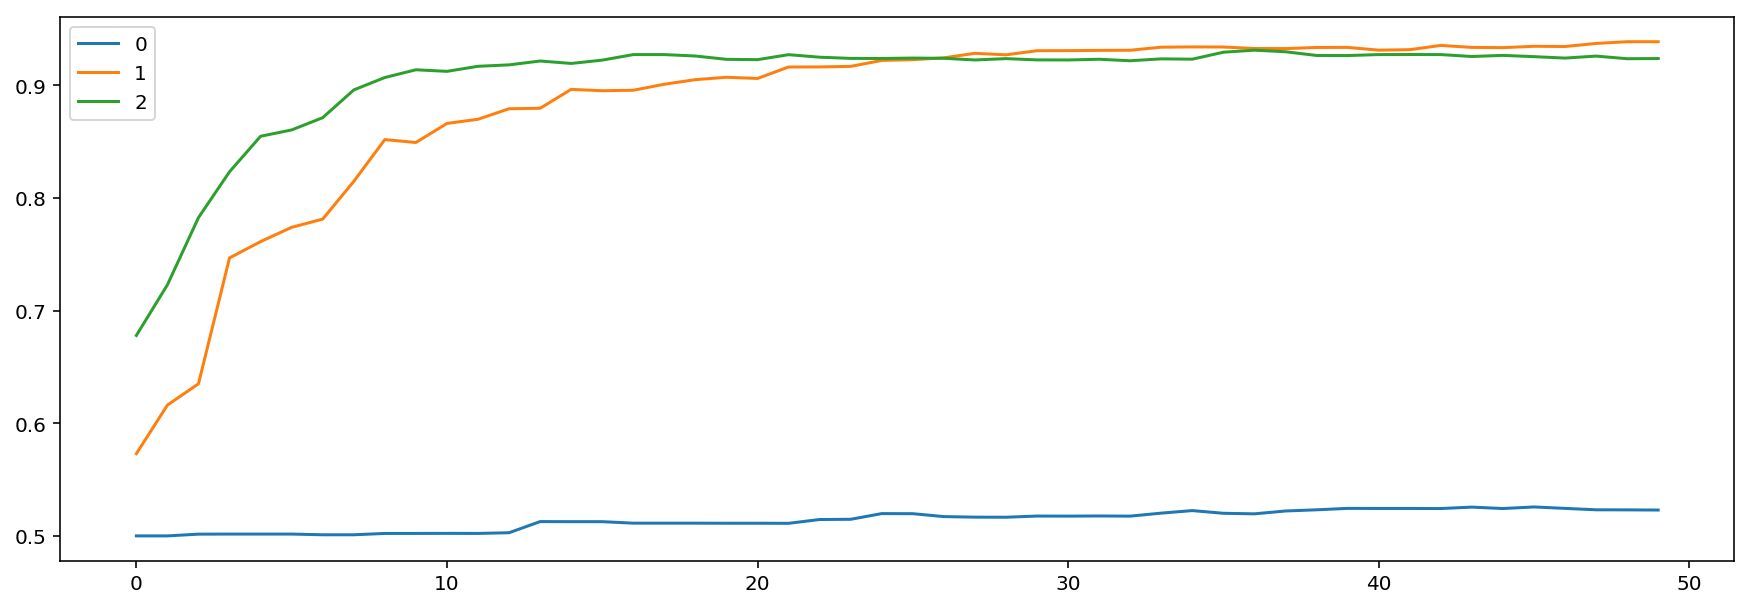

In [96]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def plot_model_accuracy(group, accuracy_scores):
    plt.figure(figsize=(15,5))
    for i, graph in enumerate(accuracy_scores):
        plt.plot(graph, label=str(i))
    plt.legend()

plot_model_accuracy('comp.graphics', accuracy_scores[0])

In [94]:
from IPython.display import HTML, display

def display_table(header, table):
    html = "<table><thead><tr>"
    for title in header:
        html += "<th>" + title + "</th>"
    html += "</tr></thead><tbody>"
    for row in table:
        html += "<tr>"
        for cell in row:
            html += "<td>" + cell.replace("\n","<br>") + "</td>"
        html += "</tr>"
    html += "</tbody></table>"
    display(HTML(html))
    
display_table(["Newsgroup", "Chi2", "Mutual Information"], keywords_table)

Newsgroup,Chi2,Mutual Information
rec.autos,13835.704846 car1680.386538 brake1630.270521 engine1360.804507 ford1175.691940 dealer1121.089666 oil974.545455 mustang953.564807 wagon935.887075 sho921.979916 tire834.919368 toyota744.760858 wheel737.719553 convertible668.436953 taurus653.488333 saturn630.193144 sedan602.513532 gt593.728804 integra576.099669 chevy555.683840 mph,0.077285 car0.014150 engine0.012154 ford0.010092 dealer0.009626 toyota0.008313 drive0.007349 mustang0.007006 auto0.006730 sedan0.006365 wheel0.006191 wagon0.006035 oil0.005956 chevy0.005865 taurus0.005842 mile0.005825 honda0.005753 compartment0.005605 vehicle0.005572 gt0.005524 rear


# Disadvantages of Univariate Feature Selection

What are the disadvanges of using mutual information for feature selection? There are cases when a single feature is useless by itself, but becomes useful in combination with other features. But in practice, as we shown in the example in this article, it works well. Finding the best combination of features is NP-complete.


# Other Methods of Feature Selection



- http://scikit-learn.org/stable/modules/feature_selection.html
- https://machinelearningmastery.com/an-introduction-to-feature-selection/
- http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/
- http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
- http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
- http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

- https://thuijskens.github.io/2017/10/07/feature-selection/

L1-penalty SVM is a surprisingly good feature selection algorithm for some tasks 

